Name: Zhuoyuan Xu (Kallen Xu)

NetID: zx1137

Due Date: Feb 22, 2021

**Gradient Descent for Ridge(less) Linear Regression**

# Feature Normalization

**Problem 1**

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy.linalg as LA
import copy

In [2]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    # The first way to implement this function: looping
    train_min = []
    train_max = []
    train_normalized = train
    test_normalized = test
    kept_col = []
    for idx in range(len(train[0])):
        train_min.append(train[:, idx].min())
        train_max.append(train[:, idx].max())
        if abs(train_max[idx]-train_min[idx]) > 1e-6:
            train_normalized[:, idx] = (train_normalized[:, idx]-train_min[idx])/(train_max[idx]-train_min[idx])
            test_normalized[:, idx] = (test_normalized[:, idx]-train_min[idx])/(train_max[idx]-train_min[idx])
            kept_col.append(idx)
    train_normalized = train_normalized[:, kept_col]
    test_normalized = test_normalized[:, kept_col]
    
    
    # The second way to implement this function: broadcasting
    #train_min = train_normalized.min(axis = 0)
    #train_max = train_normalized.max(axis = 0)
    #train_normalized = np.delete(train, np.all(train_min == train_max), 1)
    #train_normalized = np.delete(test, np.all(train_min == train_max), 1)
    #train_normalized = (train_normalized - train_min) / (train_max - train_min)
    #test_normalized = (test_normalized - train_min)/(train_max - train_min)
    
    return train_normalized, test_normalized

In [3]:
def load_data():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    return X_train, y_train, X_test, y_test

In [4]:
X_train, y_train, X_test, y_test = load_data()
print(X_train)

loading the dataset
Split into Train and Test
Scaling all to [0, 1]
[[1.         1.         1.         ... 0.13241261 0.13241261 1.        ]
 [1.         1.         1.         ... 0.92975578 0.92975578 1.        ]
 [1.         1.         1.         ... 0.91055382 0.91055382 1.        ]
 ...
 [1.         0.         0.         ... 0.04886354 0.04886354 1.        ]
 [1.         1.         1.         ... 0.58441163 0.58441163 1.        ]
 [0.         0.         0.         ... 0.03210449 0.03210449 1.        ]]


# Linear Regression

**Problem 2**

The objective function $J(\theta)$ in matrix/vector expression can be written as
$$J(\theta)=\frac{1}{m}||X\theta^T-y||^2_2$$

**Problem 3**

The gradient of $J$ can be written as 
$$\nabla_\theta J(\theta)=\frac{2}{m}X^T(X\theta^T-y)$$

**Problem 4**

The expression for updating $\theta$ in the gradient descent algorithm for a step size $\eta$ is
$$\theta^{t+1}=\theta^t-\eta^t\nabla_\theta J(\theta)=\theta^t-\eta^t(\frac{2}{m}X^T(X(\theta^T)^t-y))$$

**Problem 5**

In [5]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    m = len(X)
    #loss = (X @ np.transpose(theta) - y.T) @ np.transpose((X @ np.transpose(theta) - y.T))/m
    loss = LA.norm(X@theta.T - y.T)**2/m
    return loss

**Problem 6**

In [6]:
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    m = len(X)
    grad = 2 * (X.T @ X @ theta.T - X.T @ y.T) / m
    return grad

# Gradient Checker

**Problem 7**

In [7]:
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta). If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    e = [0] * num_features
    for i in range(num_features):
        e_i = copy.deepcopy(e)
        e_i[i] = 1
        approx_grad[i] = (compute_square_loss(X, y, theta+epsilon*np.array(e_i)) - compute_square_loss(X, y, theta-epsilon*np.array(e_i)))/(2*epsilon)
    dist = LA.norm(approx_grad - true_gradient)
    return dist <= tolerance

# Batch Gradient Descent

**Problem 8**

In [8]:
def batch_grad_descent(X, y, alpha, num_step, grad_check):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    
    theta = np.zeros(num_features)  #Initialize theta
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)
    
    for s in range(1, num_step+1):
        theta_hist[s] = theta_hist[s-1] - alpha * compute_square_loss_gradient(X, y, theta_hist[s-1])
        loss_hist[s] = compute_square_loss(X, y, theta_hist[s])
        if grad_check:
            if grad_checker(X, y, theta_hist[s]) == False:
                print('Overflow step size', alpha, 'and num step', num_step)
                break

    return theta_hist, loss_hist

**Problem 9**

In this problem, I plotted 2 different subplots because I think the "number of steps" in this problem can be explained as (1) the number of steps in each full-run of algorithm and (2) the process/steps in one run of algorithm. They are essentially the same because we are running batch gradient descent, and result in the same conclusion.

Overflow step size 0.5 and num step 5
Overflow step size 0.5 and num step 10
Overflow step size 0.5 and num step 50
Overflow step size 0.5 and num step 100
Overflow step size 0.5 and num step 200
Overflow step size 0.5 and num step 500
Overflow step size 0.5 and num step 1000
Overflow step size 0.1 and num step 50
Overflow step size 0.1 and num step 100
Overflow step size 0.1 and num step 200
Overflow step size 0.1 and num step 500
Overflow step size 0.1 and num step 1000


Text(0.5, 0.98, 'Problem 9: Average Square Loss on Training Set')

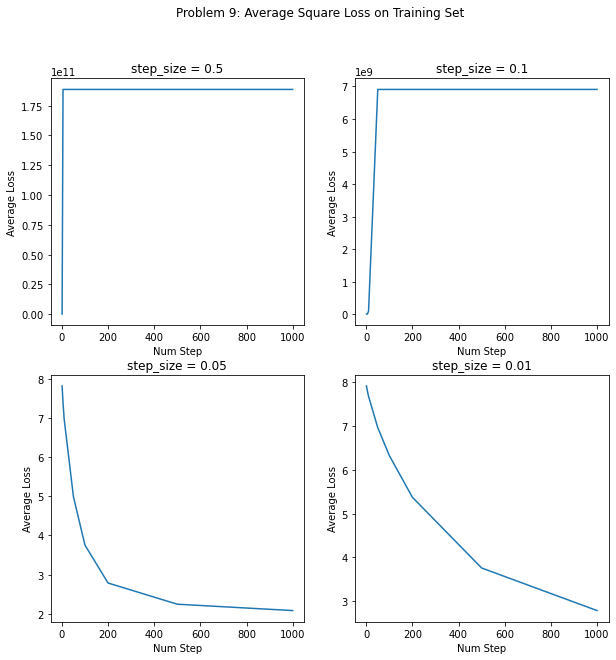

In [10]:
# Plot each number of iterations chosen to complete the each run of gradient descent algorithm
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
steps = [0.5, 0.1, 0.05, 0.01]
numstep = [1, 5, 10, 50, 100, 200, 500, 1000]
i = 0
for s in steps:
    loss = []
    for n in numstep:
        theta_hist, loss_hist = batch_grad_descent(X_train, y_train, s, n, True)
        temp = [e for e in loss_hist if e!= 0][-1]
        loss.append(temp)
    ax[i//2, i%2].plot(numstep, loss)
    ax[i//2, i%2].set_xlabel('Num Step')
    ax[i//2, i%2].set_ylabel('Average Loss')
    ax[i//2, i%2].set_title('step_size = {}'.format(s))
    i += 1
fig.suptitle('Problem 9: Average Square Loss on Training Set')

Overflow step size 0.5 and num step 1000
Overflow step size 0.1 and num step 1000


Text(0.5, 0.98, 'Problem 9: Average Square Loss on Training Set')

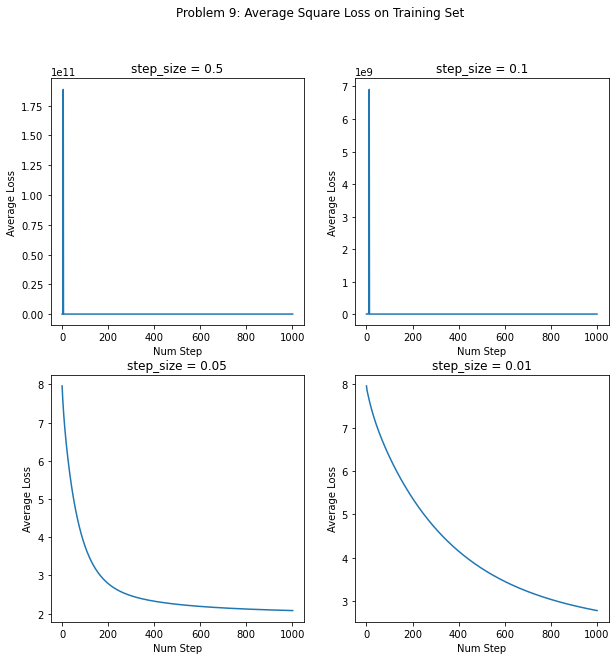

In [14]:
# Plot change in each step in one run of the gradient descent algorithm
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
steps = [0.5, 0.1, 0.05, 0.01]
numstep = 1000
i = 0
for s in steps:
    theta_hist, loss_hist = batch_grad_descent(X_train, y_train, s, numstep, True)
    ax[i//2, i%2].plot(np.linspace(0, 1001, 1001), loss_hist)
    ax[i//2, i%2].set_xlabel('Num Step')
    ax[i//2, i%2].set_ylabel('Average Loss')
    ax[i//2, i%2].set_title('step_size = {}'.format(s))
    i += 1
fig.suptitle('Problem 9: Average Square Loss on Training Set')

Note in the first subplot, on the top 2 plots, because the grad_checker notifies the function to stop updating the theta and loss once there is calculation overflow, the averge losses for large num step stays at the last updated value utill the algorithm stops. Thus the plots has relatively horizontal line segment on the graph. In the bottom subplot, the error went back to 0 because the algorithm overflows/diverges quickly so the loss and coefficients were not updated.

The plots for step sizes 0.5 and 0.1 quickly diverges and the error greatly increases as the number of steps used in the batch gradient descent function increases. Moreover, the larger step size 0.5 causes overflow in calculation quicker than 0.1. For smaller step sizes 0.05 and 0.01, the batch gradient descent converges, and the larger one 0.05 converges quicker than 0.01. In batch gradient descent, there may be a threshold between step sizes which lead to convergence or divergence. Larger step sizes may cause the function to get over the optimial point and thus lead to divergence.

**Problem 10**

I had the same concern in the problem as well, so I decide to have 2 different sets of subplots.

Overflow step size 0.5 and num step 5
Overflow step size 0.5 and num step 20
Overflow step size 0.5 and num step 100
Overflow step size 0.5 and num step 200
Overflow step size 0.5 and num step 500
Overflow step size 0.5 and num step 1000
Overflow step size 0.5 and num step 5000
Overflow step size 0.1 and num step 20
Overflow step size 0.1 and num step 100
Overflow step size 0.1 and num step 200
Overflow step size 0.1 and num step 500
Overflow step size 0.1 and num step 1000
Overflow step size 0.1 and num step 5000


Text(0.5, 0.98, 'Problem 10: Average Square Loss on Test Set')

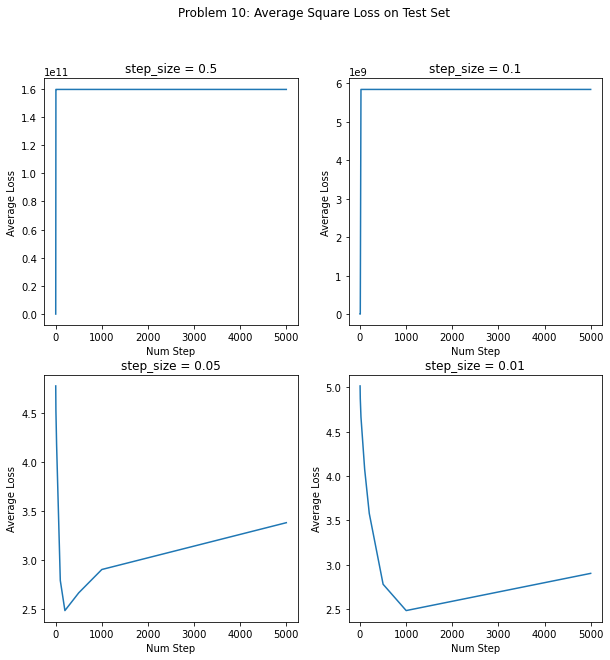

In [11]:
# Plot each number of iterations chosen to complete the each run of gradient descent algorithm
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
steps = [0.5, 0.1, 0.05, 0.01]
numstep = [1, 5, 20, 100, 200, 500, 1000, 5000]
i = 0
for s in steps:
    testloss = []
    for n in numstep:
        theta_hist, loss_hist = batch_grad_descent(X_train, y_train, s, n, True)
        theta = [e for e in theta_hist if e[0]!= 0][-1]
        testloss.append(compute_square_loss(X_test, y_test, theta))
    ax[i//2, i%2].plot(numstep, testloss)
    ax[i//2, i%2].set_xlabel('Num Step')
    ax[i//2, i%2].set_ylabel('Average Loss')
    ax[i//2, i%2].set_title('step_size = {}'.format(s))
    i += 1
fig.suptitle('Problem 10: Average Square Loss on Test Set')

Overflow step size 0.5 and num step 1000
Overflow step size 0.1 and num step 1000


Text(0.5, 0.98, 'Problem 10: Average Square Loss on Test Set')

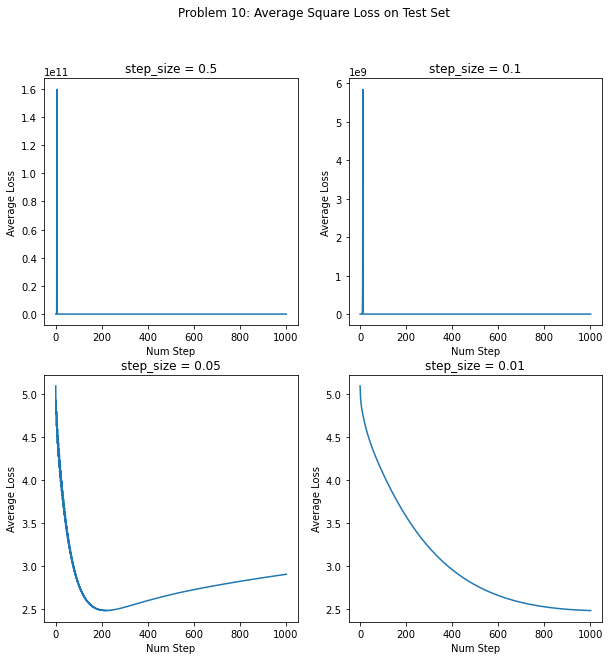

In [16]:
# Plot change in each step in one run of the gradient descent algorithm
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
steps = [0.5, 0.1, 0.05, 0.01]
numstep = 1000
i = 0
for s in steps:
    testloss = []
    theta_hist, loss_hist = batch_grad_descent(X_train, y_train, s, numstep, True)
    for j in range(len(theta_hist)):
        testloss.append(compute_square_loss(X_test, y_test, theta_hist[j]))
    ax[i//2, i%2].plot(np.linspace(0, 1001, 1001), testloss)
    ax[i//2, i%2].set_xlabel('Num Step')
    ax[i//2, i%2].set_ylabel('Average Loss')
    ax[i//2, i%2].set_title('step_size = {}'.format(s))
    i += 1
fig.suptitle('Problem 10: Average Square Loss on Test Set')

Again, note in the first subplot, on the top 2 plots, because the grad_checker notifies the function to stop updating the theta and loss once there is calculation overflow, the averge losses for large num step stays at the last updated value utill the algorithm stops. Thus the plots has relatively horizontal line segment on the graph. In the bottom subplot, the error went back to 0 because the algorithm overflows/diverges quickly so the loss and coefficients were not updated.

When step size = 0.5 or 0.1, the algorithm diveregs too quickly in both the training and the test with the tested number of steps. With smaller step size = 0.05 or 0.01, the error first decreases and then increases because of overfitting. The differences between step size = 0.05 and 0.01, as we can observe in this problem, is that the number of iterations leading to overfitting actually increases as the step size decreases.

# Ridge Regression

**Problem 11**

The gradient for the regularized objective function is $$\nabla J_\lambda (\theta)=\frac{2}{m}X^T(X\theta^T-y)+2\lambda\theta^T$$

The expression for updating $\theta$ in the gradient descent algorithm for a step size $\eta$ is
$$\theta^{t+1}=\theta^t-\eta^t\nabla J_\lambda (\theta)=\theta^t-\eta^t\frac{2}{m}X^T(X(\theta^T)^t-y)-\eta^t2\lambda(\theta^T)^t$$

**Problem 12**

In [20]:
def compute_regularized_square_loss(X, y, theta, lambda_reg):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    m = len(X)
    loss = LA.norm(X @ theta.T - y.T) **2 / m + 2 * LA.norm(theta.T)
    return loss

In [19]:
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    m = len(X)
    grad = 2 * (X.T @ X @ theta.T - X.T @ y.T) / m + 2 * lambda_reg * theta.T
    return grad

**Problem 13**

In [18]:
def regularized_grad_descent(X, y, alpha, lambda_reg, num_step):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    
    theta = np.zeros(num_features)  #Initialize theta
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)
    
    grad_check = True
    
    for s in range(1, num_step+1):
        theta_hist[s] = theta_hist[s-1] - alpha * compute_regularized_square_loss_gradient(X, y, theta_hist[s-1], lambda_reg)
        loss_hist[s] = compute_square_loss(X, y, theta_hist[s])
        if grad_check:
            if grad_checker(X, y, theta_hist[s]) == False:
                print('Overflow lambda', lambda_reg, 'and num step', num_step)
                break
    
    return theta_hist, loss_hist

**Problem 14**

I have the same concern for problem 14 and 15 with 9 and 10: 
"In this problem, I plotted 2 different subplots because I think the "number of steps" in this problem can be explained as (1) the number of steps in each full-run of algorithm and (2) the process/steps in one run of algorithm. They are essentially the same because we are running batch gradient descent, and result in the same conclusion."

Overflow lambda 100 and num step 50
Overflow lambda 100 and num step 100
Overflow lambda 100 and num step 200
Overflow lambda 100 and num step 500
Overflow lambda 100 and num step 1000
Overflow lambda 100 and num step 2000


Text(0.5, 0.98, 'Problem 14: Average Square Loss on Test Set')

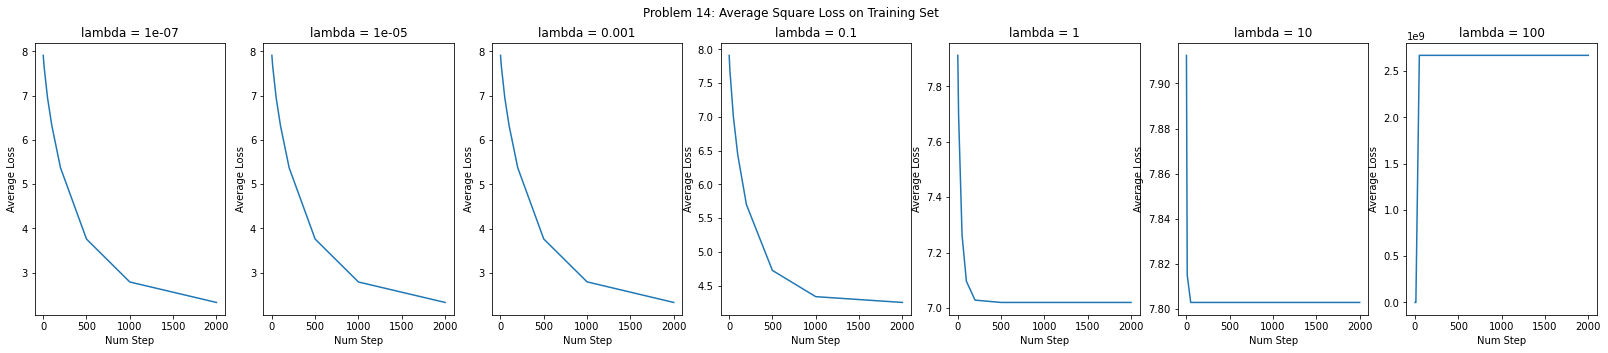

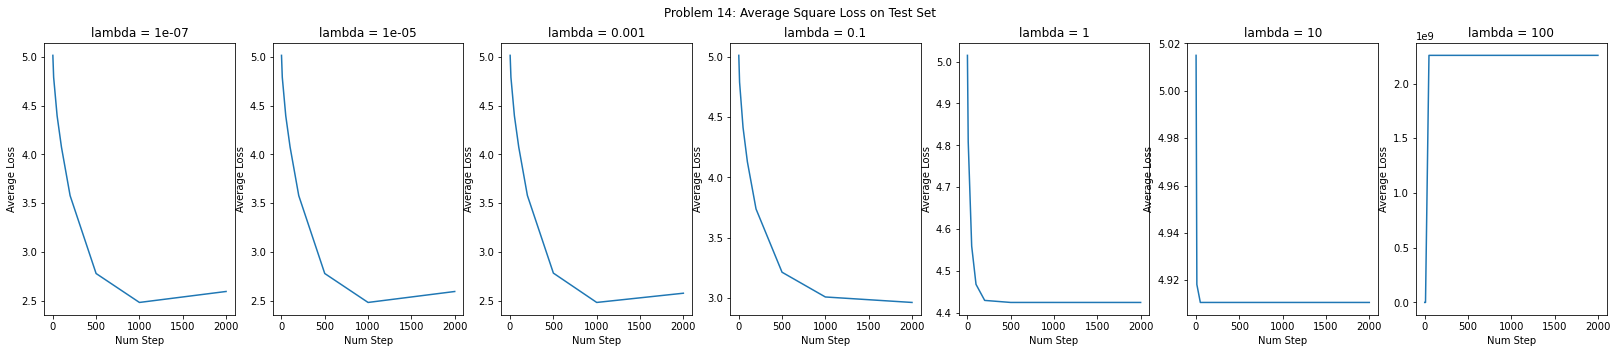

In [15]:
fig1, ax1 = plt.subplots(1, 7, figsize=(28, 5))
fig2, ax2 = plt.subplots(1, 7, figsize=(28, 5))
step = 0.01
numstep = [1, 10, 50, 100, 200, 500, 1000, 2000]
lambda_reg = [10**(-7), 10**(-5), 10**(-3), 10**(-1), 1, 10, 100] 
i = 0
for l in lambda_reg:
    loss = []
    testloss = []
    for n in numstep:
        theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, step, l, n)
        temp = [e for e in loss_hist if e!= 0][-1]
        loss.append(temp)
        theta = [e for e in theta_hist if e[0]!= 0][-1]
        testloss.append(compute_square_loss(X_test, y_test, theta))
    ax1[i].plot(numstep, loss)
    ax1[i].set_xlabel('Num Step')
    ax1[i].set_ylabel('Average Loss')
    ax1[i].set_title('lambda = {}'.format(l))
    ax2[i].plot(numstep, testloss)
    ax2[i].set_xlabel('Num Step')
    ax2[i].set_ylabel('Average Loss')
    ax2[i].set_title('lambda = {}'.format(l))
    i += 1
fig1.suptitle('Problem 14: Average Square Loss on Training Set')
fig2.suptitle('Problem 14: Average Square Loss on Test Set')

Note on the plot for lambda 100 on training set, because the grad_checker notifies the function to stop updating the theta and loss once there is calculation overflow, the averge losses for large num step stays at the last updated value utill the algorithm stops. It can be seen that the loss increases first and then the overflow error happens.

When lambda increases, the number of iterations at which overfitting starts increases, i.e. lambda helps reduce overfitting. However, when lambda is too large, the model has he risk of being underfitted, and thus the test error greatly increases.

Overflow lambda 100 and num step 2000


Text(0.5, 0.98, 'Problem 14: Average Square Loss on Test Set')

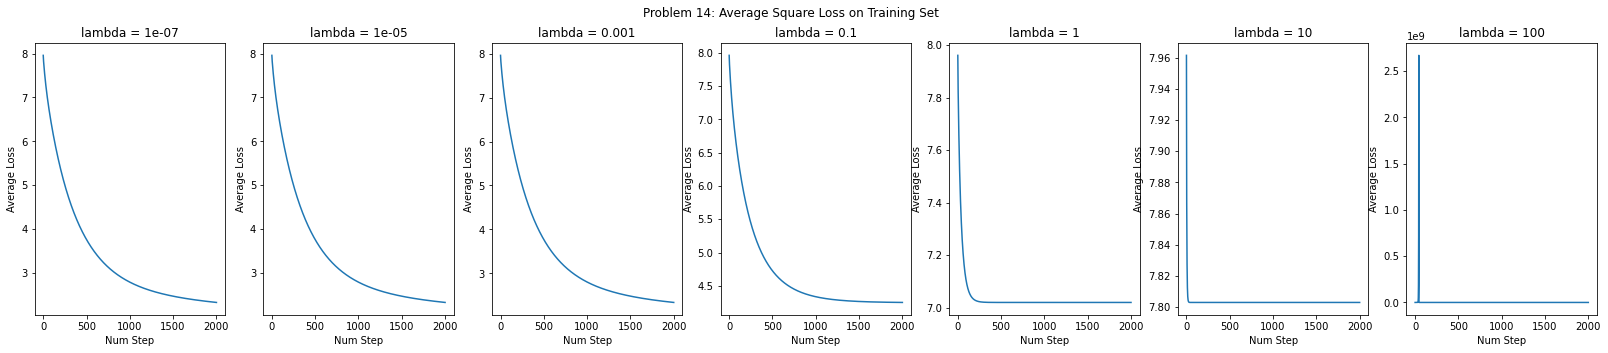

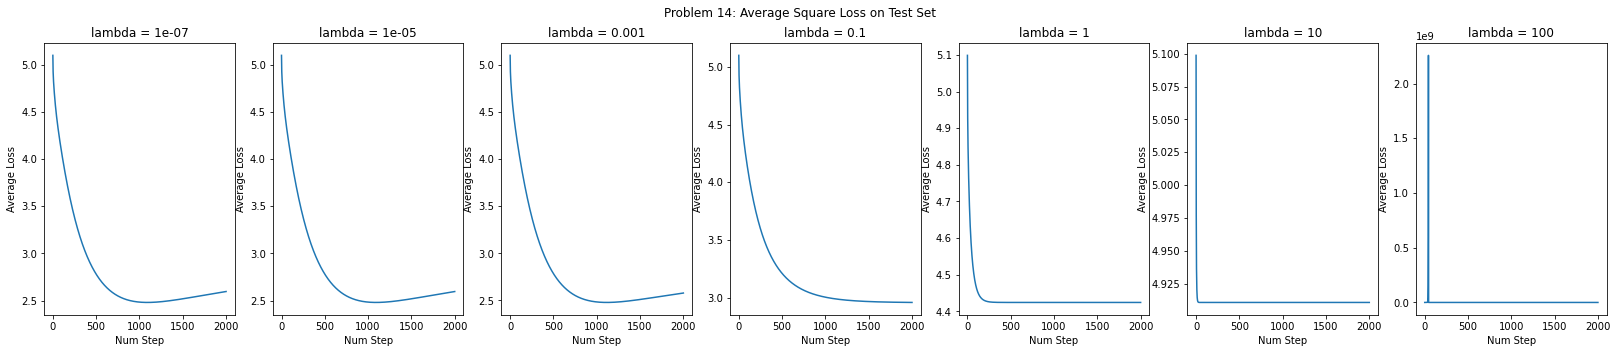

In [24]:
fig1, ax1 = plt.subplots(1, 7, figsize=(28, 5))
fig2, ax2 = plt.subplots(1, 7, figsize=(28, 5))
step = 0.01
numstep = 2000
lambda_reg = [10**(-7), 10**(-5), 10**(-3), 10**(-1), 1, 10, 100] 
i = 0
for l in lambda_reg:
    testloss = []
    theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, step, l, numstep)
    for j in range(len(theta_hist)):
        testloss.append(compute_square_loss(X_test, y_test, theta_hist[j]))
    ax1[i].plot(np.linspace(0, 2001, 2001), loss_hist)
    ax1[i].set_xlabel('Num Step')
    ax1[i].set_ylabel('Average Loss')
    ax1[i].set_title('lambda = {}'.format(l))
    ax2[i].plot(np.linspace(0, 2001, 2001), testloss)
    ax2[i].set_xlabel('Num Step')
    ax2[i].set_ylabel('Average Loss')
    ax2[i].set_title('lambda = {}'.format(l))
    i += 1
fig1.suptitle('Problem 14: Average Square Loss on Training Set')
fig2.suptitle('Problem 14: Average Square Loss on Test Set')

Note in this set of subplots, the error went back to 0 when lambda is 100 because the algorithm overflows/diverges quickly so the loss and coefficients were not updated.

Similar trend of overfitting with the previous plot can be made in this set of subplots as well: increasing lambda helps reduce overfitting, but too large a lambda may lead to underfitting as well.

**Problem 15**

Text(0.5, 0.98, 'Problem 15: Average Square Loss on Test Set')

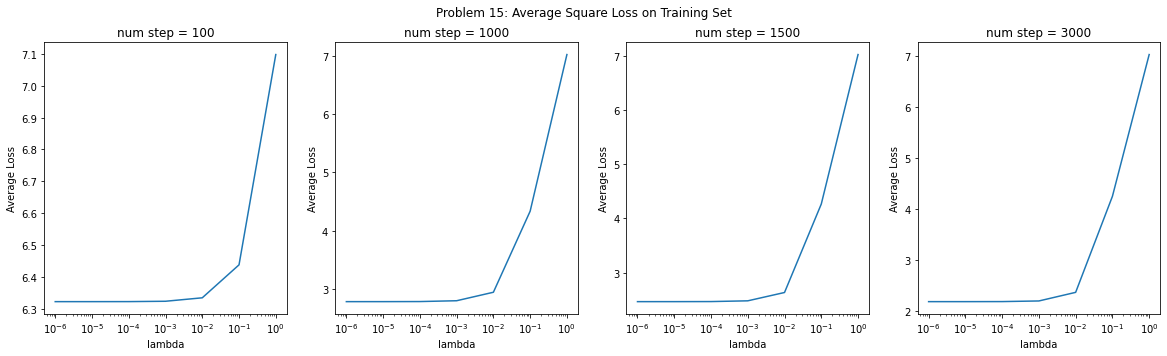

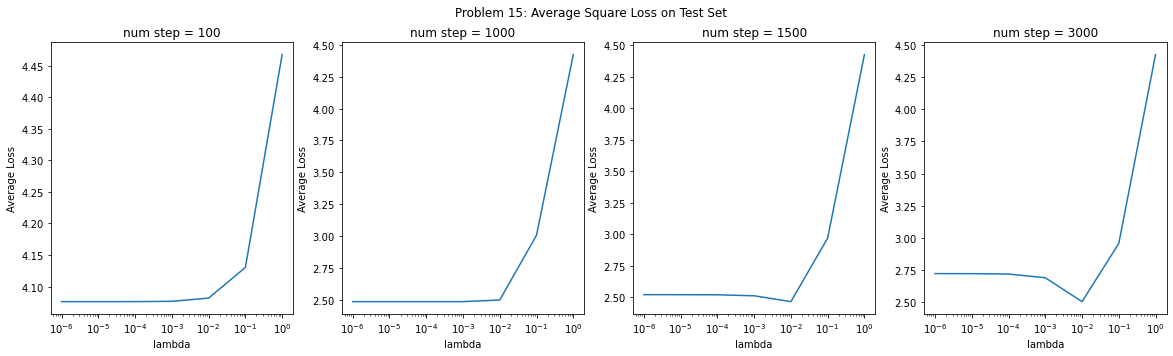

In [16]:
fig1, ax1 = plt.subplots(1, 4, figsize=(20, 5))
fig2, ax2 = plt.subplots(1, 4, figsize=(20, 5))
step = 0.01
numstep = [100, 1000, 1500, 3000]
lambda_reg = [10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 1]
i = 0
for n in numstep:
    loss = []
    testloss = []
    theta_record = []
    for l in lambda_reg:
        theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, step, l, n)
        temp = [e for e in loss_hist if e!= 0][-1]
        loss.append(temp)
        theta = [e for e in theta_hist if e[0]!= 0][-1]
        testloss.append(compute_square_loss(X_test, y_test, theta))
    ax1[i].plot(lambda_reg, loss)
    ax1[i].set_xlabel('lambda')
    ax1[i].set_ylabel('Average Loss')
    ax1[i].set_title('num step = {}'.format(n))
    ax1[i].set_xscale('log')
    ax2[i].plot(lambda_reg, testloss)
    ax2[i].set_xlabel('lambda')
    ax2[i].set_ylabel('Average Loss')
    ax2[i].set_title('num step = {}'.format(n))
    ax2[i].set_xscale('log')
    i += 1
fig1.suptitle('Problem 15: Average Square Loss on Training Set')
fig2.suptitle('Problem 15: Average Square Loss on Test Set')

We may want to choose lambda = 0.01 under our settings and the tested values. When lambda = 0.01, the average loss on both the test and the training sets at multiple num steps are relatively small, and the overfitting were reduced as well. At larger number of steps the test error reaches a minimum at lambda = 0.01.

**Problem 16**

Text(0.5, 0.98, 'Problem 16: Average Square Loss on Test Set with/without Early Stopping')

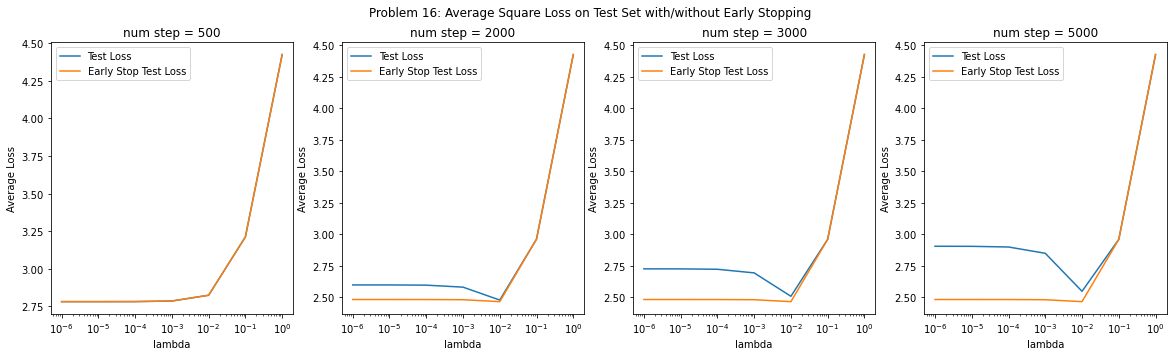

In [17]:
# I re-run the entire algorithm to separate my answers for each question.
fig2, ax2 = plt.subplots(1, 4, figsize=(20, 5))
step = 0.01
numstep = [500, 2000, 3000, 5000]
lambda_reg = [10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 1]
i = 0
for n in numstep:
    loss = []
    testloss = []
    theta_temp = []
    best_loss = []
    for l in lambda_reg:
        theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, step, l, n)
        theta = [e for e in theta_hist if e[0]!= 0][-1]
        theta_temp.append(theta)
        testloss.append(compute_square_loss(X_test, y_test, theta))
        best_loss.append(np.min([compute_square_loss(X_test, y_test, e) for e in theta_hist if e[0]!=0]))
        
    ax2[i].plot(lambda_reg, testloss, label = 'Test Loss')
    ax2[i].plot(lambda_reg, best_loss, label = 'Early Stop Test Loss')
    ax2[i].set_xlabel('lambda')
    ax2[i].set_ylabel('Average Loss')
    ax2[i].set_title('num step = {}'.format(n))
    ax2[i].set_xscale('log')
    ax2[i].legend(('Test Loss', 'Early Stop Test Loss'), loc='upper left')
    i += 1

fig2.suptitle('Problem 16: Average Square Loss on Test Set with/without Early Stopping')

From the plot, we can still choose the same lambda as before, but the choice can be altered if more lambda values are tested.

**Problem 17**

In practice we want to select the lambda that gives the lowest testing error with acceptable or relatively small training error, because we want to generalize the model. Sometimes low training error may shows overfitting, and thus gives larger test errors. After exploring the optimal lambda value, we can run through different number of steps and step sizes that also leads to minimal test error as possible. Then with these hyperparameters, we can decide the corresponding theta to use.

# Stochastic Gradient Descent (Optional)

**Problem 18**

The objective function $$J_\lambda(\theta)=\frac{1}{m}\sum_{i=1}^{m}(h_\theta(x_i)-y_i)^2+\lambda\theta^T\theta$$ can be written as $$J_\lambda(\theta)=\frac{1}{m}\sum_{i=1}^{m}((h_\theta(x_i)-y_i)^2+\lambda\theta^T\theta)$$
since SGD picks one point at a time and $\frac{1}{m}(m(\lambda\theta^T\theta))=\lambda\theta^T\theta$

Thus, $$f_i(\theta)=(h_\theta(x_i)-y_i)^2+\lambda\theta^T\theta$$ with objective function $$J_\lambda(\theta)=\frac{1}{m}\sum_{i=1}^{m}f_i(\theta)$$

**Problem 19**

With our objective function written inside the summation, the gradient can be written as $$\nabla J_\lambda(\theta)=\nabla\frac{1}{m}\sum_{i=1}^{m}f_i(\theta)$$
Since gradient is a linear operation, $$\nabla J_\lambda(\theta)=\frac{1}{m}\sum_{i=1}^{m}\nabla f_i(\theta)$$
Recall the expected value formula, the expected value of this gradient is the sum of all possible choices of i, which is sampled uniformly at random from {1, ..., m} $$E[\nabla f_i(\theta)]=\nabla\sum^m_{j=1}P(j=i)f_i(\theta)$$
We can also move the gradient into the summation, $$E[\nabla f_i(\theta)]=\frac{1}{m}\sum^m_{j=1}f_i(\theta)$$
Therefore, $$E[\nabla f_i(\theta)]=\nabla J_\lambda(\theta)$$

**Problem 20**

From the previous problems, we can write the gradient of our $f_i(\theta)$ as 
$$\begin{split}\nabla f_i(\theta)&=\nabla((h_\theta(x_i)-y_i)^2+\lambda\theta^T\theta)\\&=2(h_\theta(x_i)-y_i)\nabla h_\theta(x_i)+2\lambda\theta\\&=2((h_\theta(x_i)-y_i)x_i+\lambda\theta)\end{split}$$

The expression for updating $\theta$ in the gradient descent algorithm for a step size $\eta$ is
$$\theta^{t+1}=\theta^t-\eta^t\nabla J_\lambda (\theta)=\theta^t-\eta^t\nabla E[\nabla f_i(\theta)]$$ then we can plug in our formula for $\nabla f_i(\theta)$ and its expected value.

**Problem 21**

In [ ]:
def compute_stochastic_gradient(X, y, theta, lambda_reg):
    grad = 2 * ((theta.T @ X) - y) * X + 2 * lambda_reg * theta
    return grad

In [32]:
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta

    theta_hist = np.zeros((num_epoch, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch, num_instances)) #Initialize loss_hist
    
    theta_hist[0][0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)
    
    for i in range(1, num_epoch):
        randomidx = np.random.permutation(num_instances)
        
        for j in randomidx:            
            Xi = X[j]
            yi = y[j]
            theta = theta - alpha * compute_stochastic_gradient(Xi, yi, theta, lambda_reg)
            theta_hist[i][j] = theta
            loss_hist[i][j] = compute_square_loss(X, y, theta) + lambda_reg * (theta.T @ theta)
    
    return theta_hist, loss_hist

**2 Image Classification with Regularized Logistic Regression**

# Logistic Regression

**Problem 23**

In [25]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [27]:
def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]

In [28]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()
demoX, demoy = sub_sample(1, X_train, y_train)

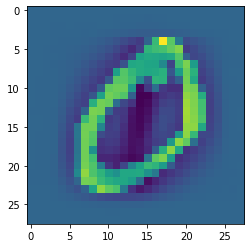

In [29]:
plt.imshow(demoX.reshape((28, 28)))

The general formula of log-likelihood on each data point can be written as a function of the margin, $$l(\theta)=log(1+e^{-margin})$$ where margin is defined as $yh_{\theta,b}(x)$. 

Then the average on m observations is $$L(\theta)=\frac{1}{m}\sum_{i=1}^{m}log(1+e^{-margin})$$

This problem is a binary classification with $y_i\in \{-1, 1\}$, and thus the logistic loss can be written in log-likelihood as
$$\begin{split}
L(\theta)
&=\frac{1}{m}\sum_{i=1}^{m}(\frac{1}{2}(1+y_i)log(1+e^{-margin_{y=1}})+\frac{1}{2}(1-y_i)log(1+e^{-margin_{y=-1}}))\\
&=\frac{1}{2m}\sum_{i=1}^{m}((1+y_i)log(1+e^{-margin_{y=1}})+(1-y_i)log(1+e^{-margin_{y=-1}}))\\
&=\frac{1}{2m}\sum_{i=1}^{m}((1+y_i)log(1+e^{-(1)h_{\theta,b}(x_i)})+(1-y_i)log(1+e^{-(-1)h_{\theta,b}(x_i)}))\\
&=\frac{1}{2m}\sum_{i=1}^{m}((1+y_i)log(1+e^{-h_{\theta,b}(x_i)})+(1-y_i)log(1+e^{h_{\theta,b}(x_i)}))
\end{split}$$

**Problem 24**

The loss function if we regularize the coefficients with $l_1$ penalty will be
$$L_\alpha(\theta)=L(\theta)+\alpha|\theta|=\frac{1}{2m}\sum_{i=1}^{m}((1+y_i)log(1+e^{-h_{\theta,b}(x_i)})+(1-y_i)log(1+e^{h_{\theta,b}(x_i)}))+\alpha|\theta|$$
where $|\theta|$ is the $l_1$ norm.

**Problem 25**

In [30]:
def classification_error(clf, X, y):
    y_pred = clf.predict(X)
    err = np.sum([i != j for i, j in zip(y_pred, y)])/len(y)
    return err

In [31]:
clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=0.01, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
clf.fit(X_train, y_train)
ce = classification_error(clf, X_test, y_test)
check = 1 - clf.score(X_test, y_test)
print('The calculated error is equal to the check:', abs(ce-check)<0.001)

-- Epoch 1
Norm: 0.70, NNZs: 289, Bias: 0.003740, T: 9902, Avg. loss: 0.041326
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 0.79, NNZs: 265, Bias: 0.003700, T: 19804, Avg. loss: 0.031012
Total training time: 0.14 seconds.
-- Epoch 3
Norm: 0.85, NNZs: 249, Bias: 0.004024, T: 29706, Avg. loss: 0.029768
Total training time: 0.20 seconds.
-- Epoch 4
Norm: 0.89, NNZs: 240, Bias: 0.004425, T: 39608, Avg. loss: 0.028902
Total training time: 0.27 seconds.
-- Epoch 5
Norm: 0.93, NNZs: 233, Bias: 0.004873, T: 49510, Avg. loss: 0.028387
Total training time: 0.33 seconds.
-- Epoch 6
Norm: 0.96, NNZs: 229, Bias: 0.005334, T: 59412, Avg. loss: 0.028036
Total training time: 0.40 seconds.
-- Epoch 7
Norm: 0.99, NNZs: 218, Bias: 0.005806, T: 69314, Avg. loss: 0.027770
Total training time: 0.46 seconds.
-- Epoch 8
Norm: 1.02, NNZs: 212, Bias: 0.006282, T: 79216, Avg. loss: 0.027561
Total training time: 0.53 seconds.
Convergence after 8 epochs took 0.53 seconds
The calculated error is equal to the

**Problem 26**

In [36]:
alp = np.linspace(10**(-4), 10**(-1), num=10)
avg = []
std = []
for value in alp:
    clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=value, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
    resX_train, resy_train = sub_sample(100, X_train, y_train)
    
    record = []
    for i in range(10):
        clf.fit(resX_train, resy_train)
        ce = classification_error(clf, X_test, y_test)
        record.append(ce)
    avg.append(np.mean(record))
    std.append(np.std(record))

-- Epoch 1
Norm: 0.31, NNZs: 505, Bias: -0.001310, T: 100, Avg. loss: 0.156598
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.35, NNZs: 420, Bias: 0.000263, T: 200, Avg. loss: 0.069432
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 467, Bias: 0.001193, T: 300, Avg. loss: 0.055485
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.39, NNZs: 487, Bias: 0.001840, T: 400, Avg. loss: 0.048111
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 491, Bias: 0.002362, T: 500, Avg. loss: 0.043278
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 497, Bias: 0.002797, T: 600, Avg. loss: 0.039772
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 500, Bias: 0.003167, T: 700, Avg. loss: 0.037070
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 502, Bias: 0.003480, T: 800, Avg. loss: 0.034912
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.44, NNZs: 503, Bias: 0.003758, T: 900, Avg. loss: 0.033123
Total training ti

-- Epoch 1
Norm: 0.30, NNZs: 607, Bias: -0.005858, T: 100, Avg. loss: 0.167683
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 604, Bias: -0.004173, T: 200, Avg. loss: 0.073696
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 551, Bias: -0.003202, T: 300, Avg. loss: 0.058389
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 502, Bias: -0.002481, T: 400, Avg. loss: 0.050432
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 479, Bias: -0.001921, T: 500, Avg. loss: 0.045277
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 457, Bias: -0.001479, T: 600, Avg. loss: 0.041577
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 436, Bias: -0.001093, T: 700, Avg. loss: 0.038724
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 420, Bias: -0.000758, T: 800, Avg. loss: 0.036437
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.43, NNZs: 416, Bias: -0.000466, T: 900, Avg. loss: 0.034556
Total tra

Norm: 0.46, NNZs: 343, Bias: 0.020104, T: 1100, Avg. loss: 0.047189
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.47, NNZs: 339, Bias: 0.020400, T: 1200, Avg. loss: 0.046027
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 0.48, NNZs: 337, Bias: 0.020678, T: 1300, Avg. loss: 0.044964
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 0.48, NNZs: 337, Bias: 0.020942, T: 1400, Avg. loss: 0.044063
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 0.49, NNZs: 335, Bias: 0.021192, T: 1500, Avg. loss: 0.043154
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 0.49, NNZs: 333, Bias: 0.021428, T: 1600, Avg. loss: 0.042464
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 0.50, NNZs: 331, Bias: 0.021655, T: 1700, Avg. loss: 0.041761
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 0.50, NNZs: 330, Bias: 0.021872, T: 1800, Avg. loss: 0.041110
Total training time: 0.02 seconds.
Convergence after 18 epochs took 0.02 seconds
-- Epoch 1
Norm: 0.30, NNZs: 389, Bias: 0.0123

Norm: 0.51, NNZs: 335, Bias: 0.023348, T: 1600, Avg. loss: 0.041880
Total training time: 0.01 seconds.
-- Epoch 17
Norm: 0.51, NNZs: 334, Bias: 0.023572, T: 1700, Avg. loss: 0.041193
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 0.52, NNZs: 334, Bias: 0.023783, T: 1800, Avg. loss: 0.040609
Total training time: 0.02 seconds.
Convergence after 18 epochs took 0.02 seconds
-- Epoch 1
Norm: 0.32, NNZs: 329, Bias: 0.003570, T: 100, Avg. loss: 0.171305
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.37, NNZs: 322, Bias: 0.005405, T: 200, Avg. loss: 0.098954
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 310, Bias: 0.006636, T: 300, Avg. loss: 0.085358
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.41, NNZs: 307, Bias: 0.007584, T: 400, Avg. loss: 0.078099
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.43, NNZs: 301, Bias: 0.008383, T: 500, Avg. loss: 0.073620
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.45, NNZs: 297, Bias: 0.009084, T: 600

Norm: 0.50, NNZs: 284, Bias: 0.020975, T: 1200, Avg. loss: 0.060253
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.51, NNZs: 283, Bias: 0.021427, T: 1300, Avg. loss: 0.059443
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 0.52, NNZs: 280, Bias: 0.021857, T: 1400, Avg. loss: 0.058661
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 0.52, NNZs: 279, Bias: 0.022268, T: 1500, Avg. loss: 0.058043
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 0.53, NNZs: 278, Bias: 0.022659, T: 1600, Avg. loss: 0.057481
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 0.54, NNZs: 278, Bias: 0.023037, T: 1700, Avg. loss: 0.056952
Total training time: 0.02 seconds.
Convergence after 17 epochs took 0.02 seconds
-- Epoch 1
Norm: 0.31, NNZs: 345, Bias: 0.010406, T: 100, Avg. loss: 0.187362
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.36, NNZs: 332, Bias: 0.012400, T: 200, Avg. loss: 0.098163
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 327, Bias: 0.013834, 

-- Epoch 1
Norm: 0.31, NNZs: 324, Bias: 0.017082, T: 100, Avg. loss: 0.190802
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.36, NNZs: 307, Bias: 0.018984, T: 200, Avg. loss: 0.114058
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 297, Bias: 0.020443, T: 300, Avg. loss: 0.100481
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.42, NNZs: 290, Bias: 0.021649, T: 400, Avg. loss: 0.093786
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.44, NNZs: 279, Bias: 0.022647, T: 500, Avg. loss: 0.089740
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.45, NNZs: 273, Bias: 0.023519, T: 600, Avg. loss: 0.086770
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.47, NNZs: 270, Bias: 0.024309, T: 700, Avg. loss: 0.084288
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 265, Bias: 0.025023, T: 800, Avg. loss: 0.082932
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.49, NNZs: 262, Bias: 0.025692, T: 900, Avg. loss: 0.081187
Total training tim

Norm: 0.51, NNZs: 265, Bias: 0.020122, T: 1000, Avg. loss: 0.081624
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.52, NNZs: 262, Bias: 0.020741, T: 1100, Avg. loss: 0.080446
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.53, NNZs: 259, Bias: 0.021334, T: 1200, Avg. loss: 0.079722
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.54, NNZs: 254, Bias: 0.021893, T: 1300, Avg. loss: 0.079136
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 0.55, NNZs: 251, Bias: 0.022422, T: 1400, Avg. loss: 0.078384
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 0.55, NNZs: 247, Bias: 0.022933, T: 1500, Avg. loss: 0.077755
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 0.56, NNZs: 242, Bias: 0.023424, T: 1600, Avg. loss: 0.077212
Total training time: 0.02 seconds.
Convergence after 16 epochs took 0.02 seconds
-- Epoch 1
Norm: 0.32, NNZs: 301, Bias: 0.015461, T: 100, Avg. loss: 0.209795
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.37, NNZs: 286, Bias: 0.017753

Norm: 0.45, NNZs: 253, Bias: 0.011948, T: 500, Avg. loss: 0.107867
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.47, NNZs: 247, Bias: 0.012922, T: 600, Avg. loss: 0.105501
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.49, NNZs: 240, Bias: 0.013816, T: 700, Avg. loss: 0.103905
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.50, NNZs: 238, Bias: 0.014635, T: 800, Avg. loss: 0.101786
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.51, NNZs: 234, Bias: 0.015407, T: 900, Avg. loss: 0.101151
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.53, NNZs: 233, Bias: 0.016127, T: 1000, Avg. loss: 0.099917
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.54, NNZs: 232, Bias: 0.016803, T: 1100, Avg. loss: 0.098927
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.55, NNZs: 225, Bias: 0.017451, T: 1200, Avg. loss: 0.098228
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 0.56, NNZs: 222, Bias: 0.018068, T: 1300, Avg. loss: 0.097400
Total training time: 

Norm: 0.55, NNZs: 204, Bias: 0.024337, T: 1100, Avg. loss: 0.116024
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.56, NNZs: 202, Bias: 0.025086, T: 1200, Avg. loss: 0.115270
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 0.57, NNZs: 197, Bias: 0.025798, T: 1300, Avg. loss: 0.114542
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 0.58, NNZs: 191, Bias: 0.026478, T: 1400, Avg. loss: 0.113862
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 0.59, NNZs: 190, Bias: 0.027131, T: 1500, Avg. loss: 0.112909
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 0.60, NNZs: 189, Bias: 0.027766, T: 1600, Avg. loss: 0.112485
Total training time: 0.02 seconds.
Convergence after 16 epochs took 0.02 seconds
-- Epoch 1
Norm: 0.34, NNZs: 276, Bias: 0.007299, T: 100, Avg. loss: 0.220991
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.39, NNZs: 257, Bias: 0.009945, T: 200, Avg. loss: 0.144285
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 244, Bias: 0.011819, 

-- Epoch 1
Norm: 0.33, NNZs: 280, Bias: 0.000561, T: 100, Avg. loss: 0.208762
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.38, NNZs: 259, Bias: 0.003598, T: 200, Avg. loss: 0.145309
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 242, Bias: 0.005677, T: 300, Avg. loss: 0.133957
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.45, NNZs: 237, Bias: 0.007290, T: 400, Avg. loss: 0.128571
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 229, Bias: 0.008685, T: 500, Avg. loss: 0.125611
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 222, Bias: 0.009905, T: 600, Avg. loss: 0.122933
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.50, NNZs: 217, Bias: 0.011028, T: 700, Avg. loss: 0.120681
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.52, NNZs: 215, Bias: 0.012053, T: 800, Avg. loss: 0.119494
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.53, NNZs: 211, Bias: 0.012990, T: 900, Avg. loss: 0.118499
Total training tim

Norm: 0.64, NNZs: 157, Bias: 0.029274, T: 1900, Avg. loss: 0.127540
Total training time: 0.02 seconds.
Convergence after 19 epochs took 0.02 seconds
-- Epoch 1
Norm: 0.33, NNZs: 270, Bias: 0.007816, T: 100, Avg. loss: 0.237302
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.39, NNZs: 246, Bias: 0.010586, T: 200, Avg. loss: 0.158711
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 231, Bias: 0.012687, T: 300, Avg. loss: 0.149679
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.45, NNZs: 219, Bias: 0.014432, T: 400, Avg. loss: 0.145035
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 210, Bias: 0.015916, T: 500, Avg. loss: 0.141188
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 204, Bias: 0.017244, T: 600, Avg. loss: 0.138672
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.51, NNZs: 201, Bias: 0.018420, T: 700, Avg. loss: 0.137751
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.53, NNZs: 192, Bias: 0.019521, T: 800, Av

-- Epoch 1
Norm: 0.33, NNZs: 245, Bias: 0.010320, T: 100, Avg. loss: 0.246951
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.38, NNZs: 224, Bias: 0.013843, T: 200, Avg. loss: 0.179245
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 211, Bias: 0.016189, T: 300, Avg. loss: 0.169667
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.45, NNZs: 200, Bias: 0.018082, T: 400, Avg. loss: 0.164150
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.48, NNZs: 190, Bias: 0.019659, T: 500, Avg. loss: 0.160332
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.50, NNZs: 181, Bias: 0.021059, T: 600, Avg. loss: 0.157814
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.52, NNZs: 176, Bias: 0.022333, T: 700, Avg. loss: 0.155247
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.53, NNZs: 170, Bias: 0.023501, T: 800, Avg. loss: 0.153357
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.55, NNZs: 165, Bias: 0.024592, T: 900, Avg. loss: 0.152164
Total training tim

-- Epoch 1
Norm: 0.32, NNZs: 236, Bias: 0.010490, T: 100, Avg. loss: 0.247248
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.38, NNZs: 221, Bias: 0.013609, T: 200, Avg. loss: 0.180343
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 207, Bias: 0.015952, T: 300, Avg. loss: 0.168623
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.45, NNZs: 195, Bias: 0.017882, T: 400, Avg. loss: 0.163135
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 190, Bias: 0.019507, T: 500, Avg. loss: 0.159394
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.50, NNZs: 184, Bias: 0.020991, T: 600, Avg. loss: 0.157555
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.51, NNZs: 178, Bias: 0.022291, T: 700, Avg. loss: 0.155278
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.53, NNZs: 174, Bias: 0.023504, T: 800, Avg. loss: 0.153737
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.55, NNZs: 172, Bias: 0.024623, T: 900, Avg. loss: 0.152539
Total training tim

-- Epoch 3
Norm: 0.46, NNZs: 206, Bias: 0.024325, T: 300, Avg. loss: 0.184768
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.49, NNZs: 189, Bias: 0.026147, T: 400, Avg. loss: 0.177832
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.51, NNZs: 179, Bias: 0.027771, T: 500, Avg. loss: 0.175820
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.53, NNZs: 171, Bias: 0.029186, T: 600, Avg. loss: 0.172716
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.55, NNZs: 162, Bias: 0.030432, T: 700, Avg. loss: 0.170601
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.56, NNZs: 159, Bias: 0.031607, T: 800, Avg. loss: 0.169068
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.58, NNZs: 157, Bias: 0.032721, T: 900, Avg. loss: 0.167686
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.59, NNZs: 151, Bias: 0.033756, T: 1000, Avg. loss: 0.166835
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.61, NNZs: 146, Bias: 0.034725, T: 1100, Avg. loss: 0.165478
Total training

-- Epoch 12
Norm: 0.59, NNZs: 140, Bias: 0.027734, T: 1200, Avg. loss: 0.165258
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 0.60, NNZs: 139, Bias: 0.028670, T: 1300, Avg. loss: 0.164758
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 0.61, NNZs: 139, Bias: 0.029574, T: 1400, Avg. loss: 0.163541
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 0.62, NNZs: 133, Bias: 0.030440, T: 1500, Avg. loss: 0.162884
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 0.63, NNZs: 132, Bias: 0.031270, T: 1600, Avg. loss: 0.162399
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 0.64, NNZs: 129, Bias: 0.032071, T: 1700, Avg. loss: 0.161745
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 0.65, NNZs: 128, Bias: 0.032846, T: 1800, Avg. loss: 0.160920
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 0.66, NNZs: 127, Bias: 0.033600, T: 1900, Avg. loss: 0.160705
Total training time: 0.03 seconds.
Convergence after 19 epochs took 0.03 seconds
-- Epoch 1
Norm: 0.34, NNZs: 235, 

Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.52, NNZs: 155, Bias: 0.030177, T: 600, Avg. loss: 0.191542
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.54, NNZs: 151, Bias: 0.031508, T: 700, Avg. loss: 0.189377
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.56, NNZs: 148, Bias: 0.032745, T: 800, Avg. loss: 0.187565
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.57, NNZs: 141, Bias: 0.033890, T: 900, Avg. loss: 0.186403
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.58, NNZs: 137, Bias: 0.034958, T: 1000, Avg. loss: 0.185181
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.60, NNZs: 130, Bias: 0.035967, T: 1100, Avg. loss: 0.183434
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.61, NNZs: 129, Bias: 0.036937, T: 1200, Avg. loss: 0.182637
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.62, NNZs: 125, Bias: 0.037865, T: 1300, Avg. loss: 0.181871
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 0.63, NNZs: 121, Bias: 0.038758, T:

Text(0.5, 0.98, 'Problem 26: Error on Different Alpha')

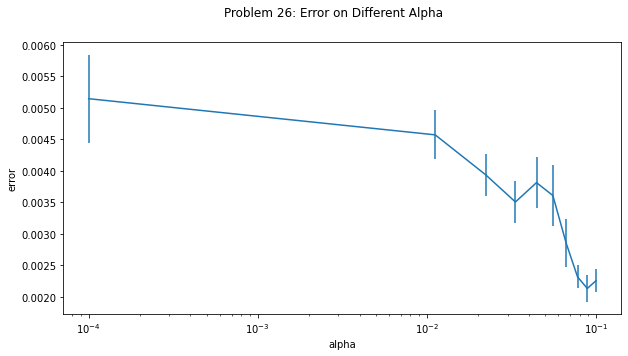

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.errorbar(alp, avg, std)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('error')
fig.suptitle('Problem 26: Error on Different Alpha')

**Problem 27**

The source of randomness we averaging over comes from the stochastic gradient descent algorithm, in which we randomly choose a data point to determine our step direction in each training iteration. Such way of choice may lead to different end coefficients to the model and thus gives different classification results and errors.

**Problem 28**

From the values we tested in this problem, the optimal value is

In [38]:
print('The optimal alpha that gives the lowest classification error on average is', alp[avg.index(np.min(avg))])

The optimal alpha that gives the lowest classification error on average is 0.0889


**Problem 29**

In [39]:
# I fit the entire process again to make the separation of each problem clearer.
alp = np.linspace(10**(-4), 10**(-1), num=10)
theta = []
for value in alp:
    clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=value, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
    clf.fit(resX_train, resy_train)
    theta.append(clf.coef_)

-- Epoch 1
Norm: 0.31, NNZs: 607, Bias: 0.011541, T: 100, Avg. loss: 0.156744
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 607, Bias: 0.012214, T: 200, Avg. loss: 0.074200
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 607, Bias: 0.012784, T: 300, Avg. loss: 0.059442
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 607, Bias: 0.013167, T: 400, Avg. loss: 0.051637
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 606, Bias: 0.013451, T: 500, Avg. loss: 0.046500
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 607, Bias: 0.013712, T: 600, Avg. loss: 0.042776
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 605, Bias: 0.013906, T: 700, Avg. loss: 0.039918
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 607, Bias: 0.014078, T: 800, Avg. loss: 0.037616
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.43, NNZs: 607, Bias: 0.014232, T: 900, Avg. loss: 0.035699
Total training tim

Alpha =  0.0001


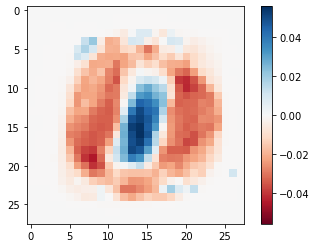

Alpha =  0.0112


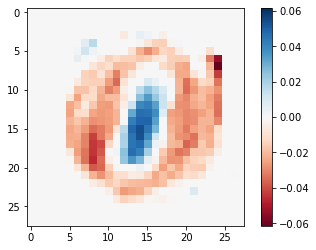

Alpha =  0.0223


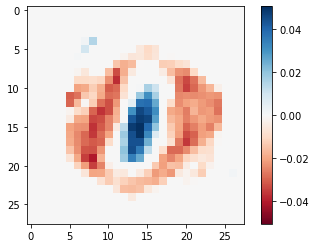

Alpha =  0.033400000000000006


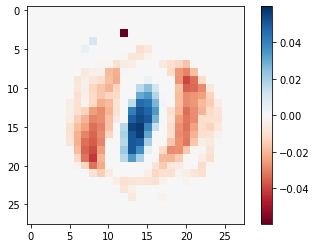

Alpha =  0.044500000000000005


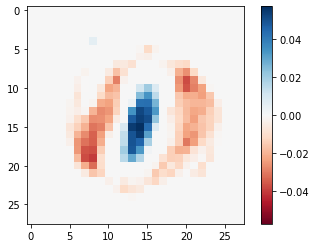

Alpha =  0.055600000000000004


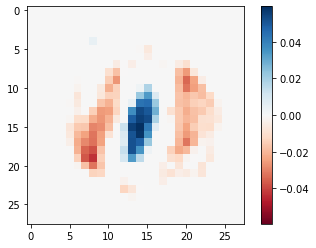

Alpha =  0.06670000000000001


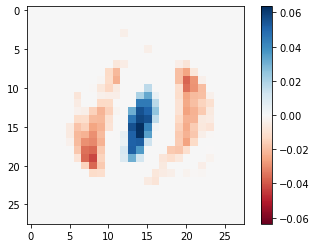

Alpha =  0.07780000000000001


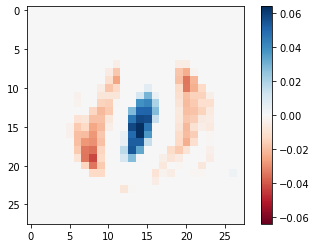

Alpha =  0.0889


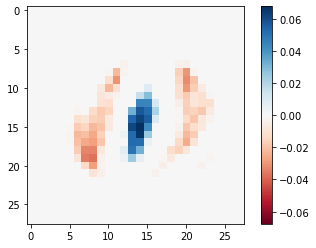

Alpha =  0.1


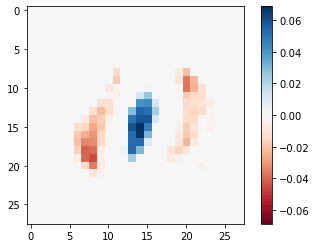

In [40]:
for i in range(len(theta)):
    print('Alpha = ', alp[i])
    scale = np.abs(theta[i]).max()
    plt.imshow(theta[i].reshape((28,28)),cmap=plt.cm.RdBu, vmax=scale, vmin=-scale)
    plt.colorbar()
    plt.show()

**Problem 30**

As alpha increases, on the images in the previous problem, areas with large magnitude, i.e. deep blue and deep red, decreases. This shows that less "extreme" values appear in the coefficients, and their values are more "centralized" because of larger penalty added by the alpha value or the regularization strength.